# Wavenet name generator

## Data preprocessing

First, let's import our dependencies:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

/home/ritsuko/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we import our dataset:

In [3]:
df = pd.read_csv("datasets/names/yob1999.csv", header=None)
# Cool idea: maybe weight this by frequency somehow?
df.columns = ["name", "gender", "count"]
df.head()

,name,gender,count
0,Emily,F,26539
1,Hannah,F,21677
2,Alexis,F,19234
3,Sarah,F,19112
4,Samantha,F,19040


We reprise our data cleaning steps from earlier:

In [4]:
# Just for today, 2023-02-22
df = df[df["gender"] == "F"]
df["name"] = df["name"].str.lower()
df

,name,gender,count
0,emily,F,26539
1,hannah,F,21677
2,alexis,F,19234
3,sarah,F,19112
4,samantha,F,19040
...,...,...,...
16939,zohal,F,5
16940,zophia,F,5
16941,zuha,F,5
16942,zuhal,F,5


Now we break up the names such that we get the preceding three chars (or ".") in one col and the char itself in another:

In [5]:
test_name = "cathey"
def split_name(name, window_size):
    pairs = []
    for idx, char in enumerate(name):
        triple = (name[max(0, idx-window_size):idx].rjust(window_size, '.'))
        pairs.append((char, triple))

    pairs.append(('.', name[max(0, len(name) - window_size):].rjust(window_size, '.')))
    return(pairs)

split_name(test_name, 5)

[('c', '.....'),
 ('a', '....c'),
 ('t', '...ca'),
 ('h', '..cat'),
 ('e', '.cath'),
 ('y', 'cathe'),
 ('.', 'athey')]

We apply this to all names:

In [6]:
pairs = df["name"].apply(lambda n: split_name(n, 8)).explode()
pairs

0        (e, ........)
0        (m, .......e)
0        (i, ......em)
0        (l, .....emi)
0        (y, ....emil)
             ...      
16943    (z, ........)
16943    (u, .......z)
16943    (z, ......zu)
16943    (u, .....zuz)
16943    (., ....zuzu)
Name: name, Length: 124361, dtype: object

We convert characters to numbers:

In [7]:
def char2idx(c):
    # Assumes valid input
    return(0 if c == "." else ord(c) - ord("a") + 1)

def idx2char(i):
    if i == 0:
        return ""
    elif i < 28:
        return(chr(i+ord("a")-1))
    else:
        return("ERR")

labels = pairs.apply(lambda p: char2idx(p[0]))
contexts = pairs.apply(lambda p: list(map(char2idx, p[1])))

Finally, we make this into tensors:

In [8]:
labels = F.one_hot(torch.tensor(labels.tolist()), 27)
# OK that we're not one-hot encoding this since we're using these as indices into an embedding matrix
contexts = torch.tensor(contexts.tolist())

Finally, we put this into a *bona fide* PyTorch dataset:

In [9]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(contexts, labels)

train_size = int(0.8 * len(contexts))
test_size = len(contexts) - train_size
train_len = int(train_size / len(dataset) * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset= torch.utils.data.random_split(dataset, [train_len,test_len])

## Training loop

### Primitives: Ghetto PyTorch

~~I'm just going to write out the entire MLP class at once. This is terrible, but my laziness and depression have forced my hand.~~ nvm we in our pytorch era fr fr, as the kids say. first we make our embedding layer:

In [40]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        # Vocab size
        self.num_embeddings = num_embeddings
        # Dimensions
        self.embedding_dim = embedding_dim
        self.weight = torch.randn(num_embeddings, embedding_dim)
    
    def __call__(self, x):
        raw = self.weight[x]
        #return(raw.view(raw.shape[0], -1))
        self.out = raw
        return(self.out)

    def parameters(self):
        return([self.weight])

Then we make the "ghetto linear layer":

In [11]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.W = torch.empty(in_features, out_features)
        nn.init.kaiming_normal(self.W, nonlinearity="tanh")
        self.hasBias = bias
        if bias:
            self.B = torch.randn(out_features) * 1e-4
    
    def __call__(self, input):
        # Assumes valid input lol
        self.out = input @ self.W
        return(self.out + self.B if self.hasBias else self.out)

    def parameters(self):
        # wtf does this do???
        return [self.W, self.B] if self.hasBias else [self.W]


### Batch normalization

Intuitively, what we're trying to do is to manually "normalize" the whole batch activations to be like the normal distribution around 0.

How we accomplish this:
- Kill bias layer in middle
- Keep running mean and stdev of batch, which we (somewhat arbitrarily) set to update by 1e-3 each cycle
- Subtract mean and divide by the standard deviation
- Add learned bias?

In [12]:
class BatchNorm1d:
    def __init__(self, num_features, eps=1e-05,momentum=0.1):
        # Learned scaling factor
        self.Gamma = torch.randn(num_features) * 1e-1
        self.Beta = torch.randn(num_features) * 1e-4
        self.eps = eps
        self.mean = 0
        self.std = 0
        self.momentum = momentum
        self.training = True

    def __call__(self, x):
        if self.training:
            res = self.Gamma * ((x - x.mean(0, keepdim=True)) / (x.std(0, keepdim=True) + self.eps)) + self.Beta
            with torch.no_grad():
                # Update learned parameters
                self.mean = (1 - self.momentum) * self.mean + self.momentum * x.mean(0)
                self.std = (1 - self.momentum) * self.std + self.momentum * x.std(0)
        else:
            res = self.Gamma * ((x - self.mean) / (self.std + self.eps)) + self.Beta

        return(res)
    
    def parameters(self):
        return([self.Gamma, self.Beta])
    


Finally, we wrap `tanh` for convenience:

In [13]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return(self.out)
    def parameters(self):
        return([])

### Sequential

For completeness, we also re-implement the PyTorch [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential) class, even though I don't really see why:

In [14]:
class Sequential:
    # Not implementing OrderedDict support unless Karpathy tells me to
    def __init__(self, *args):
        self.layers = [arg for arg in args]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return(x)

    def parameters(self):
        return([p for l in self.layers for p in l.parameters()])

    def append(self, module):
        self.layers.append(module)



In [31]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        # Batch, groups, concat
        n = self.n
        B, T, C = x.shape
        # Ex. if n == 2, double amount of data in group, halve number of groups
        x = x.view(B, T//n, C*n)
        if x.shape[1] == 1:
            # Remove extraneous T dimension
            x = x.squeeze(1)
        
        self.out = x
        return self.out
    
    def parameters(self):
        # No params, this is just a utility function
        return []

Testing matrix multiplies to make sure my intuition is correct:

### Wavenet class

In [39]:
class MLP:
    def __init__(self, embedding_size, vocab_size, block_size, hidden_size):
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.hidden_size = hidden_size

        # Hidden layer
        self.layers = Sequential(
            Embedding(vocab_size, embedding_size),
            FlattenConsecutive(2), Linear(embedding_size * 2, hidden_size), BatchNorm1d(hidden_size), Tanh(),
            FlattenConsecutive(2), Linear(embedding_size * 2, hidden_size), BatchNorm1d(hidden_size), Tanh(),
            FlattenConsecutive(2), Linear(embedding_size * 2, hidden_size), BatchNorm1d(hidden_size), Tanh(),
            Linear(hidden_size, vocab_size)
        )

        # Make less confident in front of softmax. This is terrible but VGUI has forced my hand
        self.layers.layers[-1].W *= 1e-1
        for p in self.layers.parameters():
            p.requires_grad = True

    
    def infer(self, x):
        """Returns logits for future use"""
        with torch.no_grad():
            for layer in self.layers.layers:
                if isinstance(layer, BatchNorm1d):
                    layer.training = False

            return(self.layers(x))

    def forward(self, x):
        """Takes batch of contexts; returns logits"""
        return(self.layers(x))

    def backward(self, x, y_true):
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y_true)

        # Zero out gradients
        for p in self.layers.parameters():
            p.grad = None

        loss.backward()
        return loss
    
    def update_parameters(self, lr):
        # Subtract the gradients
        with torch.no_grad():
            # There HAS to be a better way to do this
            for p in self.layers.parameters():
                p.data -= lr * p.grad

    def fit_one_cycle(self, x, y_true, lr, show_loss=False):
        loss = self.backward(x, y_true)
        if show_loss:
            print(f"Loss: {loss.item()}")
        self.update_parameters(lr)
        return(loss.item())
    


Now it merely falls to us to write the driver code:

In [41]:
VOCAB_SIZE = 27
BLOCK_SIZE = 8
BATCH_SIZE = 16
EMBEDDING_NDIM = 10
HIDDEN_NDIM = 68
STEPS=10000

# Simple exponential decay
lrs = 10 ** np.linspace(0, -3, STEPS + 1)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
model = MLP(
    embedding_size=EMBEDDING_NDIM, 
    hidden_size=HIDDEN_NDIM,
    vocab_size=VOCAB_SIZE,
    block_size=BLOCK_SIZE
)

for layer in model.layers.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))
"""
global_step = 0
epoch = 0
lossi = []
while global_step < STEPS:
    for step, (data, labels) in enumerate(train_dataloader):
        should_print = global_step % 500 == 0
        if (should_print):
            print(f"Step {global_step}:")
        loss = model.fit_one_cycle(data, labels.float(), lrs[step], should_print)
        if global_step % 10 == 0:
            lossi.append(loss)

        global_step += 1
        if global_step >= STEPS:
            break
    epoch += 1
    if global_step >= STEPS:
        break
        """


/tmp/ipykernel_47727/1279679824.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.W, nonlinearity="tanh")


AttributeError: 'Embedding' object has no attribute 'out'

What's the loss curve through training?

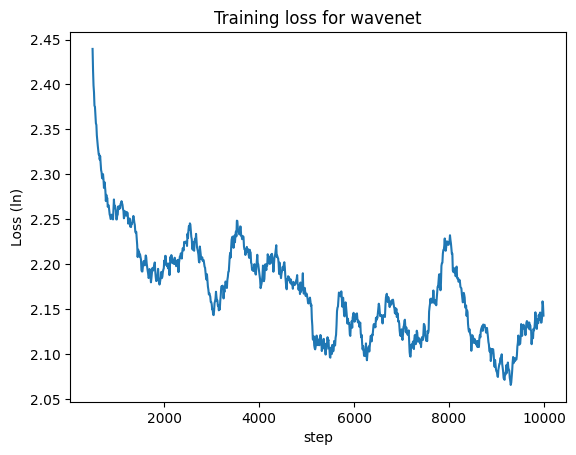

In [63]:
import matplotlib.pyplot as plt
losses = pd.DataFrame({
    "step": np.arange(0, STEPS, 10),
    "loss": lossi
})
losses["rolling_loss"] = losses["loss"].rolling(window=50).mean()
plt.plot(losses["step"], losses["rolling_loss"])
plt.xlabel("step")
plt.ylabel("Loss (ln)")
plt.title("Training loss for wavenet")
plt.show()

After some tinkering, we find that small batch sizes (8), linear decay LR from 0.5 to 1e-2, and higher steps decrease rate (severe overfitting begins...)
Finally, we get the loss on the training set (we technically need a validation, but I can't be bothered):

In [21]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_loss = 0
for data, labels in test_dataloader:
    loss = model.backward(data, labels.float())

loss

tensor(2.1259, grad_fn=<DivBackward1>)

## Generation

In [67]:
g = torch.Generator()

for _ in range(20):
    out = []
    context = [0] * model.block_size
    while True:
        logits = model.infer(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # randomly sample pred from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(idx2char(i) for i in out))

kodoly
wastora
alyania
jalon
telinza
beolane
katulive
deadah
meiete
syely
sarla
zicfynza
krertona
kveenanna
layzah
marlyn
aki
dave
mylyn
alianea


## Testing and validation

### Finding the learning rate

This hyperparameter is kind of important (citation needed). To start, we want to implement something like the "learning rate finder", where we exponentially increase lr until we hit a wall and then find it somewhere around there. Let's give it a try! Let's go from $10^{-3}$ to $10^1$ in increments of 2x???

In [60]:
lr_model = MLP(EMBEDDING_NDIM, HIDDEN_NDIM)
lr = 10e-4

# WHY IS THIS LANGUAGE NOT TYPED AARGH
losses = []
i = 0

while lr < 10:
    start, end = i * BATCH_SIZE, (i+1) * BATCH_SIZE
    loss = lr_model.backward(contexts[start:end], labels[start:end].float())
    lr_model.update_parameters(lr)
    losses.append({"loss" : loss.item(), "lr": lr})
    lr *= 1.05
    i+=1

loss_df = pd.DataFrame.from_records(losses)
loss_df["loss_smooth"] = loss_df["loss"].rolling(window=5).mean()

Loss: 7.430624008178711
Loss: 5.907592296600342
Loss: 6.736423969268799
Loss: 6.276147842407227
Loss: 8.191972732543945
Loss: 6.006835460662842
Loss: 7.029684066772461
Loss: 5.80147647857666
Loss: 6.876686096191406
Loss: 6.443017482757568
Loss: 6.2708916664123535
Loss: 5.996418476104736
Loss: 6.9694013595581055
Loss: 7.181060314178467
Loss: 7.285386562347412
Loss: 6.76036262512207
Loss: 4.900427341461182
Loss: 6.592562198638916
Loss: 7.163669586181641
Loss: 6.860597133636475
Loss: 6.350022315979004
Loss: 6.802441120147705
Loss: 5.725580215454102
Loss: 6.045586109161377
Loss: 7.162632465362549
Loss: 6.112359046936035
Loss: 6.745479106903076
Loss: 8.428348541259766
Loss: 7.566260814666748
Loss: 7.213047027587891
Loss: 6.1751508712768555
Loss: 6.329876899719238
Loss: 5.869903087615967
Loss: 6.829679489135742
Loss: 7.537769317626953
Loss: 6.489545822143555
Loss: 6.2317705154418945
Loss: 6.0110626220703125
Loss: 7.265320301055908
Loss: 8.121577262878418
Loss: 6.227502822875977
Loss: 6.25087

Now let's graph this:

In [53]:
import matplotlib.pyplot as plt

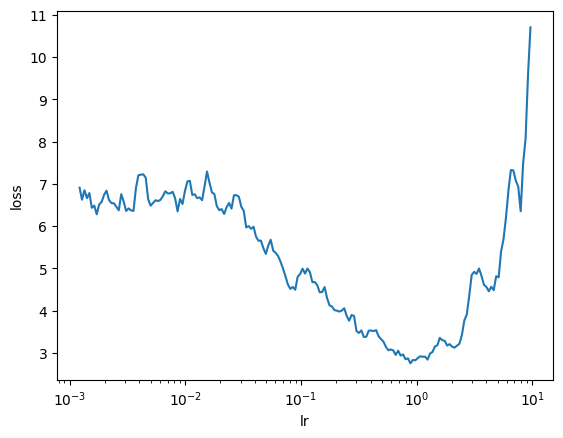

In [61]:
plt.plot(loss_df['lr'], loss_df['loss_smooth'])
plt.xscale('log')
plt.xlabel('lr')
plt.ylabel('loss')
plt.show()


Looks like our initial learning rate wasn't aggressive enough! torch.linspace, -3, 0 10** that. instead of what we did here

## Generation